In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

import copy
import abc
import math
from random import random, choices, randint, shuffle, normalvariate
from tqdm.auto import tqdm as tqdm
from collections import defaultdict, Counter
import graphviz
from multiprocessing import Pool
from IPython.display import clear_output
import pickle
import time
import traceback

sns.set()

In [60]:
"""
Classes and methods for working with nondeterministic finite automata.
Source: https://github.com/caleb531/automata
"""


def ddict2dict(d):
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = ddict2dict(v)
    return dict(d)


def retries_for_sample(kappa: int) -> int:
    return math.ceil(
        (2 + math.log(4) + 8 * math.log(kappa)) / math.log(1.0 / (1.0 - math.exp(-9.0)))
    )


class AutomatonException(Exception):
    """The base class for all automaton-related errors."""

    pass


class InvalidStateError(AutomatonException):
    """A state is not a valid state for this automaton."""

    pass


class InvalidSymbolError(AutomatonException):
    """A symbol is not a valid symbol for this automaton."""

    pass


class MissingStateError(AutomatonException):
    """A state is missing from the automaton definition."""

    pass


class RejectionException(AutomatonException):
    """The input was rejected by the automaton."""

    pass


class Automaton(metaclass=abc.ABCMeta):
    """An abstract base class for all automata, including Turing machines."""

    @abc.abstractmethod
    def __init__(self):
        """Initialize a complete automaton."""
        raise NotImplementedError

    @abc.abstractmethod
    def validate(self):
        """Return True if this automaton is internally consistent."""
        raise NotImplementedError

    @abc.abstractmethod
    def read_input_stepwise(self, input_str):
        """Return a generator that yields each step while reading input."""
        raise NotImplementedError

    def read_input(self, input_str, validate_final=True):
        """
        Check if the given string is accepted by this automaton.

        Return the automaton's final configuration. If validate_final is true,
        this will return the final configuration only if this string is valid,
        raising RejectionException otherwise.
        """
        validation_generator = self.read_input_stepwise(
            input_str, validate_final=validate_final
        )
        for config in validation_generator:
            pass
        return config

    def accepts_input(self, input_str):
        """Return True if this automaton accepts the given input."""
        try:
            self.read_input(input_str)
            return True
        except RejectionException:
            return False

    def _validate_initial_states(self):
        """Raise an error if any of the initial states is invalid."""
        invalid_states = self.initial_states - self.states
        if invalid_states:
            raise InvalidStateError(
                "inital states are not valid ({})".format(
                    ", ".join(str(state) for state in invalid_states)
                )
            )

    def _validate_initial_states_transitions(self):
        """Raise an error if any initial state has no transitions defined."""
        for initial_state in self.initial_states:
            if initial_state not in self.transitions:
                raise MissingStateError(
                    "initial state {} has no transitions defined".format(initial_state)
                )

    def _validate_final_states(self):
        """Raise an error if any final states are invalid."""
        invalid_states = self.final_states - self.states
        if invalid_states:
            raise InvalidStateError(
                "final states are not valid ({})".format(
                    ", ".join(str(state) for state in invalid_states)
                )
            )

    def copy(self):
        """Create a deep copy of the automaton."""
        return self.__class__(**vars(self))

    def __eq__(self, other):
        """Check if two automata are equal."""
        return vars(self) == vars(other)


class FA(Automaton, metaclass=abc.ABCMeta):
    """An abstract base class for finite automata."""

    pass


class NFA(FA):
    """A nondeterministic finite automaton."""

    def __init__(
        self,
        *,
        states,
        input_symbols,
        transitions,
        initial_states,
        final_states,
        states_by_layer=None,
        reverse_transitions=None,
    ):
        """Initialize a complete NFA."""
        self.states = states.copy()
        self.input_symbols = input_symbols.copy()
        self.transitions = copy.deepcopy(transitions)
        self.initial_states = initial_states
        self.final_states = final_states.copy()
        #self.validate()

        # --- Counting utilities ---
        self.states_by_layer = states_by_layer
        self.sketch = defaultdict(dict)
        self.n_for_sets = {}
        self.n_for_states = {}
        self.s_for_states = defaultdict(Counter)
        self.reverse_transitions = reverse_transitions
        self.sorted_symbols = sorted(self.input_symbols)

    def _validate_transition_invalid_symbols(self, start_state, paths):
        """Raise an error if transition symbols are invalid."""
        for input_symbol in paths.keys():
            if input_symbol not in self.input_symbols and input_symbol != "":
                raise InvalidSymbolError(
                    "state {} has invalid transition symbol {}".format(
                        start_state, input_symbol
                    )
                )

    def _validate_transition_end_states(self, start_state, paths):
        """Raise an error if transition end states are invalid."""
        for end_states in paths.values():
            for end_state in end_states:
                if end_state not in self.states:
                    raise InvalidStateError(
                        "end state {} for transition on {} is "
                        "not valid".format(end_state, start_state)
                    )

    def validate(self):
        """Return True if this NFA is internally consistent."""
        for start_state, paths in self.transitions.items():
            self._validate_transition_invalid_symbols(start_state, paths)
            self._validate_transition_end_states(start_state, paths)
        self._validate_initial_states()
        self._validate_initial_states_transitions()
        self._validate_final_states()
        return True

    def _get_next_current_states(self, current_states, input_symbol):
        """Return the next set of current states given the current set."""
        next_current_states = set()
        for current_state in current_states:
            symbol_end_states = self.transitions.get(current_state, {}).get(input_symbol)
            if symbol_end_states:
                for end_state in symbol_end_states:
                    next_current_states.add(end_state)

        return next_current_states

    def _check_for_input_rejection(self, current_states):
        """Raise an error if the given config indicates rejected input."""
        if not (current_states & self.final_states):
            raise RejectionException(
                "the NFA stopped on all non-final states ({})".format(
                    ", ".join(str(state) for state in current_states)
                )
            )

    def read_input_stepwise(self, input_str, validate_final=True):
        """
        Check if the given string is accepted by this NFA.

        Yield the current configuration of the NFA at each step.
        """
        # current_states = self._get_epsilon_closure(self.initial_state)
        current_states = self.initial_states

        yield current_states
        for input_symbol in input_str:
            current_states = self._get_next_current_states(current_states, input_symbol)
            yield current_states

        if validate_final:
            self._check_for_input_rejection(current_states)

    def reachable(self, input_str: str, state) -> bool:
        """
        Returns true if the NFA reaches the state after reading input_str
        """
        return bool(self.read_input(input_str, validate_final=False) & set([state]))

    @staticmethod
    def remove_unreachable_states(initial_states: set, transitions: dict, n: int):
        """
        Filters states that are unreachable from an initial state
        by traversing one layer at a time.

        It returns a tuple of the form
        (
            all_reachable_states: set of states,
            reachable_states_by_layer: dict of layer -> set of states,
            reachable_transitions: dict of state p -> symbol a -> state q,
            rev_reachable_transitions: dict of state q -> symbol a -> state p,
        )

        Note that here states are tuples of strings (former states) and layer integers.
        """
        reachable_states_by_layer = {0: initial_states}
        all_reachable_states = initial_states.copy()
        for next_layer in range(1, n + 1):
            this_layer_reachable = reachable_states_by_layer[next_layer - 1]
            next_layer_reachable = set()
            for current_state in this_layer_reachable:
                for new_states in transitions[current_state].values():
                    for new_state in new_states:
                        next_layer_reachable.add(new_state)
            all_reachable_states.update(next_layer_reachable)
            reachable_states_by_layer[next_layer] = next_layer_reachable

        reachable_transitions = defaultdict(lambda: defaultdict(set))
        rev_reachable_transitions = defaultdict(lambda: defaultdict(set))

        for p, trans in transitions.items():
            if p not in all_reachable_states:
                print(f"Unreachable state {p} was removed")
                continue
            for a, qs in trans.items():
                for q in qs:
                    if q not in all_reachable_states:
                        print(f"Unreachable state {q} was removed")
                        continue
                    reachable_transitions[p][a].add(q)
                    rev_reachable_transitions[q][a].add(p)

        return (
            all_reachable_states,
            reachable_states_by_layer,
            reachable_transitions,
            rev_reachable_transitions,
        )

    def unroll(self, n: int):
        """
        Builds A_unroll with n levels
        to estimate |L(F^n)|
        """
        # for each state q ∈ Q, include copies q_0 , q_1 , ..., q n in A unroll
        new_states = {(q, i) for q in self.states for i in range(1, n + 1)}
        # new_states_by_layer = {i: {(q,i) for q in self.states} for i in range(1, n+1)}
        new_states.update({(q, 0) for q in self.initial_states})
        # new_states_by_layer = {0: {(q,0) for q in self.initial_states}}

        # for each transition (p, a, q) ∈ ∆ and i ∈ {0, 1, . . . , n − 1}, include
        # transition (p_i, a, q_i+1) in A unroll
        new_transitions = defaultdict(lambda: defaultdict(set))
        rev_transitions = defaultdict(lambda: defaultdict(set))
        for p, trans in self.transitions.items():
            for a, qs in trans.items():
                for q in qs:
                    for i in range(n):
                        # state -> symbol -> set of states
                        new_transitions[p, i][a].add((q, i + 1))
                        rev_transitions[q, i + 1][a].add((p, i))

        new_initial_states = {(q, 0) for q in self.initial_states}
        new_final_states = {(q, n) for q in self.final_states}
        # cleanup of unreachable states
        (
            new_states,
            new_states_by_layer,
            new_transitions,
            rev_transitions,
        ) = NFA.remove_unreachable_states(
            initial_states=new_initial_states, transitions=new_transitions, n=n
        )
        new_transitions = ddict2dict(new_transitions)
        rev_transitions = ddict2dict(rev_transitions)
        nfa_unroll = NFA(
            states=new_states,
            input_symbols=self.input_symbols,
            transitions=new_transitions,
            initial_states=new_initial_states,
            final_states=new_final_states,
            states_by_layer=new_states_by_layer,
            reverse_transitions=rev_transitions,
        )

        return nfa_unroll

    def compute_n_for_single_state(self, state):
        """
        Compute N(pᵅ) = Σ N(R_b) for R_b being the set of
        incoming states which connect to pᵅ after reading symbol b.

        In simple terms, it receives a states and estimates
        the number of different strings leading to it.
        """

        if state in self.n_for_states:
            return self.n_for_states[state]

        # will store all the N(Pᵅ) calculated with `compute_n_for_states_set`
        n_r_b = {}
        for b, leading_states in self.reverse_transitions.get(state, {}).items():
            # leading_states = self.reverse_transitions[state][b]
            n_r_b[b] = self.compute_n_for_states_set(frozenset(leading_states))
            # print(f"{state=}, {leading_states=}, n_r_b[{b=}]={n_r_b[b]}")
        n_q_alpha = sum(n_r_b.values())
        self.n_for_states[state] = n_q_alpha
        return n_q_alpha

    def compute_n_for_states_set(self, states: frozenset):
        """
        Compute N(Pᵅ) = Σ N(pᵅ)· |S(pᵅ)-Union(L(qᵅ) for q ≺ p)| / |S(pᵅ)|

        In simple terms, it receives a set of states and estimates
        the number of different strings leading to all of them.
        """
        if not states:
            return 0
        if states in self.n_for_sets:
            return self.n_for_sets[states]

        states_list = sorted(states)  # linear order ≺
        # Count the first state in the list alone
        total = self.n_for_states[states_list[0]]
        for i in range(1, len(states_list)):
            # states[i] = (q, i), where q is the original state name in A
            anchor_state = states_list[i]
            intersection_count = 0
            s_size = 0
            # Now estimate the intersection rate for anchor_state
            for string, count in self.s_for_states[anchor_state].items():
                s_size += count
                for previous_state in states_list[:i]:
                    if not self.reachable(input_str=string, state=previous_state):
                        intersection_count += count
            intersection_rate = intersection_count / s_size if s_size > 0 else 0
            # print(
            #     "inside n_states_set",
            #     anchor_state,
            #     self.n_for_states,
            #     intersection_rate,
            # )
            total += self.compute_n_for_single_state(anchor_state) * intersection_rate
        # cache the result
        self.n_for_sets[states] = total
        return total

    def sample(self, beta: int, states: frozenset, curr_string: str, phi: float):
        # print(f"sample({beta=}, {states=},{curr_string=})")
        if beta == 0:
            if random() <= phi:
                return curr_string
            return "fail"
            # return curr_string
        # will store all the states on layer i-1
        # which lead to r after reading b={0,1}
        # {'0': {...leading_states}, '1': {...leading_states}}
        p_beta_b = {}
        # will store all the N(Pᵅ) calculated with `compute_n_for_states_set`
        n_p_beta_b = {}

        for b in self.sorted_symbols:
            all_leading_states = set()
            for r in states:
                all_leading_states.update(
                    self.reverse_transitions.get(r, {}).get(b, set())
                )
            fzset = frozenset(all_leading_states)
            # print(f"{fzset=}")
            p_beta_b[b] = fzset
            n_p_beta_b[b] = self.compute_n_for_states_set(fzset)
        # print(f"{n_p_beta_b=}")
        sum_n_p_beta = sum(n_p_beta_b.values())
        if sum_n_p_beta == 0:
            return None
        chosen_symbol = choices(
            self.sorted_symbols,
            weights=[n_p_beta_b[b] / sum_n_p_beta for b in self.sorted_symbols],
            k=1,
        )[0]
        curr_string = chosen_symbol + curr_string  # w_beta-1 = b · w_beta
        chosen_states = p_beta_b[chosen_symbol]  # p_beta-1
        new_probability = phi / (n_p_beta_b[chosen_symbol] / sum_n_p_beta)  # phi / p_b
        return self.sample(
            beta=beta - 1,
            states=chosen_states,
            curr_string=curr_string,
            phi=new_probability,
        )

    def count_accepted(self, n: int, eps: float):
        """
        Returns a (1 ± ε)-approximation of |L_n(A_unroll)|
        """
        kappa = math.ceil(n * len(self.states) / eps)
        # c(κ)
        retries_sample = retries_for_sample(kappa)
        print("Retries per sample", retries_sample)
        sample_size = 2 * (kappa ** 2)  # 2 * kappa ** 7
        print("Sample size", sample_size)
        exp_minus_five = math.exp(-5)
        # For each state q ∈ I, set N(q_0) = |L(q_0)| = 1
        # and S(q_0) = L(q_0) = {λ}
        for q in self.states_by_layer[0]:
            self.s_for_states[q] = {"": sample_size}
            self.n_for_states[q] = 1

        # For each i = 1, . . . , n and state q ∈ Q:
        #   (a) Compute N(q i ) given sketch[i − 1]
        #   (b) Sample polynomially many uniform elements from L(q_i) using
        #       N(q_i) and sketch[i − 1], and let S(q_i) be the multiset of
        #       uniform samples obtained
        for i in tqdm(range(1, n + 1), desc="Layer", position=0):
            for q in tqdm(self.states_by_layer[i], desc=f"State at layer {i}", position=1, leave=False):

                n_q_alpha = self.compute_n_for_single_state(q)
                if n_q_alpha == 0:
                    raise ValueError("oops")
                this_q_samples = Counter()
                # sample probability
                phi = exp_minus_five / n_q_alpha
                for _ in tqdm(range(sample_size), desc="Sampling", position=2, leave=False):
                    sampled_successfully = False
                    for retry in range(retries_sample):
                        potential_sample = self.sample(
                            beta=i, states=frozenset([q]), curr_string="", phi=phi
                        )
                        if potential_sample == "fail":
                            continue
                        elif potential_sample is None:
                            continue
                        this_q_samples.update([potential_sample])
                        sampled_successfully = True
                        break
                    if not sampled_successfully:
                        return 0

                self.s_for_states[q] = this_q_samples

        return self.compute_n_for_states_set(frozenset(self.final_states))

    def bruteforce_save_all(self, n: int):
        if n == 0:
            return [""] if self.accepts_input("") else []
        accepted_strings = []
        for i in range(2 ** n):
            string_i = bin(i)[2:].zfill(n)
            if self.accepts_input(string_i):
                accepted_strings.append(string_i)
        return accepted_strings

    def bruteforce_count_only(self, n: int):
        if n == 0:
            return 1 if self.accepts_input("") else 0
        accepted_count = 0
        for i in tqdm(range(2 ** n)):
            string_i = bin(i)[2:].zfill(n)
            if self.accepts_input(string_i):
                accepted_count += 1
        return accepted_count

    def bruteforce_dfs(self, n: int):
        if n == 0:
            return 1 if self.accepts_input("") else 0
        accepted_count = 0
        visit_queue = [(s, 0) for s in self.initial_states]  # FIFO queue
        while visit_queue:
            curr_state, curr_len = visit_queue.pop(-1)
            if curr_len == n:
                if curr_state in self.final_states:
                    accepted_count += 1
                continue
            for symbol, next_states in self.transitions.get(curr_state, {}).items():
                for next_state in next_states:
                    visit_queue.append((next_state, curr_len + 1))
        return accepted_count

    def plot(self):
        dot = graphviz.Digraph(
            name="NFA", graph_attr={"rankdir": "LR", "ranksep": "0.5", "nodesep": "0.6"}
        )

        for s in self.states:
            if s in self.final_states:
                dot.node(s, shape="doublecircle")
            else:
                dot.node(s, shape="circle")
                
            if s in self.initial_states:
                dot.node(f"{s}_init", label="", shape="none", height="0", width="0")
                dot.edge(f"{s}_init", s)

        for curr_state, symbol_next_states in self.transitions.items():
            defer_labels = []
            for symbol, next_states in symbol_next_states.items():
                for next_state in next_states:
                    if next_state == curr_state:
                        defer_labels.append(symbol)
                        continue
                    dot.edge(curr_state, next_state, label=symbol)
            if defer_labels:
                dot.edge(curr_state, curr_state, label=",".join(defer_labels))

        return dot
    
    @staticmethod
    def random_trans_sparse(states_list: list, input_symbols: set = {"0", "1"}, sparsity=0.5):
        """
        Generates random transitions for the states
        q_0 ... q_{n_states}, using the input_symbols.
        
        Each pair of states can be connected with up to 
        one symbol transition, as the symbol is
        chosen at random to form a transition matrix.
        """
        n_states = len(states_list)
        # choose the transitions as a random matrix over the alphabet and the
        # empty symbol, represented by -1
        matrix_choices = list(input_symbols | {"-1"})
        transition_matrix = np.random.choice(matrix_choices, size=(n_states, n_states))
        transitions = {}
        for i, from_state in enumerate(states_list):
            transitions_from_state = defaultdict(set)
            for j, to_state in enumerate(states_list):
                if transition_matrix[i,j] in input_symbols:
                    symbol = str(transition_matrix[i,j])
                    transitions_from_state[symbol].add(to_state)
            transitions[from_state] = transitions_from_state
            
        return transitions
        
        
    @staticmethod
    def random_trans_ambiguous(states_list: list, input_symbols: set = {"0", "1"}, sparsity: float = 1/3):
        """
        Generates random transitions for the states
        q_0 ... q_{n_states}, using the input_symbols.
        
        Each pair of states may be connected with every
        available symbol, as a subset is chosen at
        random for each pair.
        """
        
        input_list = list(input_symbols)
        
        transitions = {}
        for i, from_state in enumerate(states_list):
            transitions_from_state = defaultdict(set)
            for j, to_state in enumerate(states_list):
                if random() < sparsity:
                    # no transition case
                    continue
                # each symbol has constant probability 0.5 of being part of a
                # transition from_state->to_state
                for symbol in input_symbols:
                    if random() < 0.5:
                        transitions_from_state[symbol].add(to_state)
                    
                """
                # Alternative approach
                
                # Note that by choosing the subset size uniformly at random,
                # we are flattening the distribution of a random subset in
                # which each element is included in the subset with p=0.5.
                # That approach will tend to a binomial distribution on the
                # subset size, which in turn tends to a normal distribution
                # for large alphabets
                subset_size = randint(1, len(input_symbols))
                shuffle(input_list)
                subset = input_list[:subset_size]
                for symbol in subset:
                    transitions_from_state[symbol].add(to_state)
                        
                """
            transitions[from_state] = transitions_from_state
        return transitions
    
    @staticmethod
    def random(n_states: int, input_symbols: set = {"0", "1"}, sparsity: float = 1/3):
        
        states_list = [f"q{i}" for i in range(n_states)]
        states = set(states_list)
        
        transitions = NFA.random_trans_sparse(states_list=states_list, 
                                                 input_symbols=input_symbols,
                                                 sparsity=sparsity)
        
        shuffle(states_list)
        n_initial_states = max(1, min(n_states, int(normalvariate(1, (n_states**0.5) / 2))))
        initial_states = set(states_list[:n_initial_states])
        shuffle(states_list)
        n_final_states = max(1, min(n_states, int(normalvariate(1, (n_states**0.5) / 2))))
        final_states = set(states_list[:n_final_states])
        
        return NFA(
            states=states,
            input_symbols=input_symbols,
            transitions=transitions,
            initial_states=initial_states,
            final_states=final_states
        )
        
        

In [ ]:
nfa = NFA(
    states={'q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1'}, '1': {'q3'}},
        'q1': {'0': {'q2'}},
        'q2': {'0': {'q2'}, '1': {'q2'}},
        'q3': {'0': {'q4'}},
        'q4': {'0': {'q5'}},
        'q5': {'0': {'q6'}},
        'q6': {'0': {'q6'}, '1': {'q6'}},
    },
    initial_states={'q0'},
    final_states={'q2', 'q6'}
)

In [ ]:
nfa = NFA(
    states={'q0', 'q1', 'q2', 'q3'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1', 'q2'}},
        'q1': {'0': {'q1', 'q3'}},
        'q2': {'0': {'q3'}, '1': {'q2'} },
        'q3': {'0': {'q3'}},
    },
    initial_states={'q0'},
    final_states={'q3'}
)

In [ ]:
nfa = NFA(
    states={'q0', 'q1', 'q2'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1'}},
        'q1': {'1': {'q2'}},
        'q2': {'1': {'q0'}}
    },
    initial_states={'q0'},
    final_states={'q1'}
)

In [ ]:
%%time
nfa.bruteforce_count_only(25)

In [ ]:
nfa.plot()

In [ ]:
def count_nfa(nfa: NFA, n: int, eps: float):
    nfa_unroll = nfa.unroll(n)
    return nfa_unroll.count_accepted(n=n, eps=eps), nfa_unroll

In [ ]:
count, nfa_unroll = count_nfa(nfa, 55, 1500)
count

In [ ]:
1 << 50

In [ ]:
189863754266 / 1e9

In [ ]:
nfa.accepts_input('')

In [ ]:
x = np.array([1.,2.,3.])


In [ ]:
print(nfa.plot().source)
nfa.plot()

# Experimentos estadísticos

In [ ]:
nfa = NFA(
    states={'q0', 'q1', 'q2'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1'}},
        # Use '' as the key name for empty string (lambda/epsilon) transitions
        'q1': {
            #'0': {'q1'},
            '1': {'q0', 'q2'}},
        'q2': {
            '1': {'q0'}
        }
    },
    initial_states={'q0'},
    final_states={'q1'}
)

In [67]:
%%time
data = [(i,nfa.bruteforce_count_only(i)/2**i) for i in range(1, 20)]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/8192 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/32768 [00:00<?, ?it/s]

  0%|          | 0/65536 [00:00<?, ?it/s]

  0%|          | 0/131072 [00:00<?, ?it/s]

  0%|          | 0/262144 [00:00<?, ?it/s]

  0%|          | 0/524288 [00:00<?, ?it/s]

CPU times: user 26.2 s, sys: 439 ms, total: 26.6 s
Wall time: 28 s


In [ ]:
log_data = [(i, math.log(max(1, nfa.bruteforce_count_only(i)))) for i in range(1, 20)]

In [68]:
df = pd.DataFrame(data, columns=["i", "frac"])

<AxesSubplot:xlabel='i'>

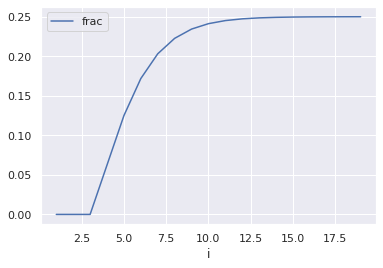

In [69]:
df.plot(x="i", y="frac")

In [52]:
df

,i,frac
0,1,0.000000
1,2,0.000000
2,3,0.000000
3,4,0.062500
4,5,0.125000
5,6,0.171875
6,7,0.203125
7,8,0.222656
8,9,0.234375
9,10,0.241211


In [ ]:
df[df.i >= 5].plot(x="i", y="frac")

In [ ]:
def fit_function(x, a, b, c):
    return a*b**(c*x)

In [ ]:
predictable_data = df[df.i.between(11,23)]

In [ ]:
x_data = predictable_data.i.values
y_data = predictable_data.frac.values
popt, pcov = scipy.optimize.curve_fit(fit_function, x_data, y_data, maxfev=1000)

In [ ]:
all_data = df[df.i >= 5]
all_x_data = all_data.i.values
all_y_data = all_data.frac.values

fig = plt.plot(all_x_data, fit_function(all_x_data, *popt), label="fit")
plt.plot(all_x_data, all_y_data, label="real")
plt.legend();
plt.title("Comparación valores predichos y reales")
plt.gcf().set_size_inches((14,8))

In [ ]:
plt.plot(all_x_data, fit_function(all_x_data, *popt) - all_y_data, label="fit")
plt.legend();
plt.title("Residuos")
plt.gcf().set_size_inches((14,8))

In [ ]:
k = 28
pred_for_k = fit_function(k, *popt) * 2**k
pred_for_k

In [ ]:
[(k,int(fit_function(k, *popt) * 2**k)) for k in range(6,28)]

In [ ]:
{{6, 13},
 {7, 23},
 {8, 44},
 {9, 81},
 {10, 148},
 {11, 274},
 {12, 504},
 {13, 927},
 {14, 1705}}

In [ ]:
%%time
ground_truth_k = nfa.bruteforce_dfs(k)
ground_truth_k

In [ ]:
popt

In [ ]:
# Error relativo!
(pred_for_k - ground_truth_k) / ground_truth_k

In [ ]:
# Error relativo!
(pred_for_k - ground_truth_k) / ground_truth_k

- https://arxiv.org/pdf/1802.04708.pdf -> si A es acíclico, el lenguaje es finito. De hecho, $L(A) \subseteq (\Sigma \cup \{\epsilon\})^{|Q|}$
- En general, para $n < |Q|$ el comportamiento se puede hardcodear, por lo que fuerza bruta o `sketch` son necesarios
- http://www.stringology.org/cgi-bin/getfile.cgi?t=pdf&c=-&y=2013&n=03 -> hay un algoritmo $O(|Q|)$ que usa `BFS` y `gcd` para determinar si la densidad del lenguaje es exponencial o polinomial. Se basa en encontrar dos caminos distintos del mismo largo y estado de partida en una componente fuertemente conexa (SCC).
    - Hipótesis 1: si el lenguaje tiene densidad exponencial, el gráfico $|L_n(A)|/2^n$ se verá como una constante tras al menos $n=|Q|$. Estimar es trivial para $n \gg |Q|$, basta retornar esa proporción multiplicada por $2^n$
    - Hipótesis 2: si el lenguaje tiene densidad polinomial, el gráfico $|L_n(A)|/2^n$ se verá como una exponencial
    decayendo. Se puede fittear una función y aproximar para $n \gg |Q|$
    
- [Scholar Kai Salomaa](https://scholar.google.com/citations?hl=es&user=N3AlqdYAAAAJ&view_op=list_works&sortby=pubdate)

Keeler, Salomaa


$|L(A)| \le \text{ambiguity} \le \text{string path width} \le \text{tree width}$

- **ambiguity**: number of accepting computations of A on a given string
- **string path width**: does not count partial computations, only complete (and maybe non-accepting) computations
- **tree width**: all computations of A on a given string (even partial ones)

In [ ]:
np.random.choice(["-1","0","1"], size=(3,3))[1,0]

In [ ]:
rand = NFA.random(n_states=5, input_symbols={"0", "1"}, sparsity=0.5)
rand.plot()

In [ ]:
rand.bruteforce_count_only(15)

In [ ]:
count, nfa_unroll = count_nfa(rand, 15, 100)
count

In [ ]:
def compare_random_to_brute(i):
    print(f"[{i}] started\n", end="")
    n_states = randint(2, 6)
    rand = NFA.random(n_states=n_states, input_symbols={"0", "1"}, sparsity=0.5)
    string_len = randint(4, 10)
    epsilon = randint(string_len, 2*string_len)
    print(f"[{i}] bruteforce started\n", end="")
    bruteforce = rand.bruteforce_count_only(string_len)
    if bruteforce < 2:
        print(f"[{i}] insufficient accepting strings")
        return 0
    try:
        t0 = time.time()
        count, nfa_unroll = count_nfa(rand, string_len, epsilon)
        t1 = time.time()
        return [n_states, rand.initial_states, rand.final_states, rand.transitions,
                       string_len, bruteforce, count, epsilon, t1 - t0]
    except Exception as e:
        return e

    
# results = [] # n_states, initial_states, final_states, transitions, string_n, bruteforce, estimate, eps, time
samples = 0
errors = []
error_count = 0
n_proc = 6
with Pool(processes=n_proc) as pool:
    while samples < 5000 and error_count < 300:
        multiproc_results = pool.map(compare_random_to_brute, range(10))
        for res in multiproc_results:
            if isinstance(res, Exception):
                errors.append(res)
                error_count += 1
                continue
            else:
                samples += 1
                if res != 0:
                    results.append(res)
        
        clear_output(wait=True)
        with open("intermediate_stats_.pkl", "wb") as fd:
            pickle.dump(results, fd)
        print(f"Wrote pickle file for {len(results)} results")
                
        

[1] started
[0] started
[2] started
[5] started
[3] started
[4] started
[5] bruteforce started
[1] bruteforce started
[2] bruteforce started
[0] bruteforce started
[4] bruteforce started
[3] bruteforce started


  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[1] insufficient accepting strings
[6] started


  0%|          | 0/16 [00:00<?, ?it/s]

[6] bruteforce started
[4] insufficient accepting stringsUnreachable state ('q2', 1) was removed

[7] started
Unreachable state ('q2', 2) was removed[7] bruteforce started

Unreachable state ('q2', 3) was removed[2] insufficient accepting strings

Unreachable state ('q3', 0) was removed[8] started
[8] bruteforce started
Unreachable state ('q0', 0) was removed
Unreachable state ('q4', 1) was removed[0] insufficient accepting strings
[9] started
[9] bruteforce started

Unreachable state ('q0', 2) was removed
Unreachable state ('q0', 3) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q1', 1) was removed
Unreachable state ('q4', 2) was removed



  0%|          | 0/32 [00:00<?, ?it/s]

Unreachable state ('q4', 3) was removed
Unreachable state ('q1', 2) was removedUnreachable state ('q5', 0) was removed

Retries per sampleUnreachable state ('q2', 0) was removed

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

 221624
Sample size 800Unreachable state ('q2', 1) was removed

Unreachable state ('q2', 3) was removed

Unreachable state ('q3', 1) was removedUnreachable state ('q3', 2) was removedUnreachable state ('q1', 0) was removed

  0%|          | 0/1024 [00:00<?, ?it/s]



Unreachable state ('q3', 3) was removed
Retries per sampleUnreachable state ('q1', 1) was removed
 Unreachable state ('q1', 2) was removed131763

Unreachable state ('q1', 3) was removed
Sample size 50
Unreachable state ('q0', 1) was removed[8] insufficient accepting stringsUnreachable state ('q1', 4) was removed


Unreachable state ('q2', 0) was removedUnreachable state ('q1', 5) was removed

Unreachable state ('q3', 0) was removedUnreachable state ('q1', 6) was removed

Unreachable state ('q4', 0) was removedUnreachable state ('q1', 7) was removed

Unreachable state ('q1', 8) was removedUnreachable state ('q5', 0) was removed

Unreachable state ('q1', 9) was removedRetries per sample 221624


Layer:   0%|          | 0/4 [00:00<?, ?it/s]

Sample size 
800
Unreachable state ('q2', 0) was removed


Layer:   0%|          | 0/4 [00:00<?, ?it/s]

Retries per sample Unreachable state ('q0', 1) was removed211089

Unreachable state ('q2', 0) was removed
Retries per sampleSample size  233442578

Sample size 1152


State at layer 1:   0%|          | 0/4 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/1 [00:00<?, ?it/s]

Wrote pickle file for 55 results


Layer:   0%|          | 0/10 [00:00<?, ?it/s]

Layer:   0%|          | 0/5 [00:00<?, ?it/s]

Layer:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/2 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/5 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1152 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/3 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1152 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1152 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1152 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/3 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1152 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1152 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1152 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

State at layer 6:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/3 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1152 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1152 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

State at layer 7:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1152 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/3 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1152 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

State at layer 8:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

In [ ]:
results

In [53]:
df = pd.DataFrame(results, columns=["n_states", "initial_states", "final_states", "transitions",
                                    "string_n", "bruteforce", "estimate", "eps", "time"])

In [54]:
df["rel_error"] = abs(df.estimate - df.bruteforce)/df.bruteforce

In [55]:
df

,n_states,initial_states,final_states,transitions,string_n,bruteforce,estimate,eps,time,rel_error
0,2,"{q1, q0}",{q0},"{'q0': {'1': {'q0'}, '0': {'q0'}}, 'q1': {'1':...",4,16,16.000000,4,1.270484,0.000000
1,4,{q3},"{q3, q0, q2}","{'q0': {}, 'q1': {}, 'q2': {}, 'q3': {'1': {'q...",5,32,63.555556,10,2.749607,0.986111
2,4,{q2},{q2},"{'q0': {'1': {'q3', 'q0', 'q1', 'q2'}, '0': {'...",5,4,4.020000,5,22.013623,0.005000
3,3,{q2},{q1},"{'q0': {'0': {'q1'}}, 'q1': {'1': {'q0'}, '0':...",6,64,63.905325,9,20.631674,0.001479
4,4,{q1},"{q3, q1, q2}","{'q0': {'1': {'q1'}, '0': {'q1'}}, 'q1': {'0':...",4,16,30.821429,7,4.054953,0.926339
5,3,{q0},{q2},"{'q0': {'1': {'q0'}, '0': {'q1', 'q0'}}, 'q1':...",6,21,21.000000,11,12.879692,0.000000
6,4,{q0},{q0},"{'q0': {'0': {'q0'}, '1': {'q3'}}, 'q1': {'1':...",6,63,131.728214,7,88.881846,1.090924
7,4,"{q3, q1, q2}","{q3, q0}","{'q0': {'1': {'q2', 'q1'}, '0': {'q3', 'q1'}},...",6,64,64.174014,12,27.759341,0.002719
8,4,{q1},"{q2, q0}","{'q0': {'0': {'q2'}}, 'q1': {'1': {'q3'}, '0':...",6,28,27.916667,8,14.537006,0.002976
9,3,"{q2, q1}",{q2},"{'q0': {'1': {'q0'}}, 'q1': {'1': {'q2', 'q0'}...",6,21,21.000000,8,25.492397,0.000000


In [3]:
with open("intermediate_stats_.pkl", "rb") as fd:
    results = pickle.load(fd)
        

In [64]:
rand = NFA.random(n_states=4, input_symbols={"0", "1"}, sparsity=0.5)

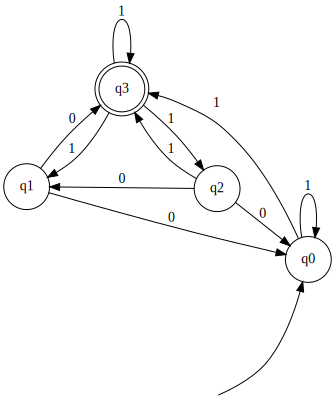

In [65]:
rand.plot()

In [66]:
rand.bruteforce_count_only(6)

  0%|          | 0/64 [00:00<?, ?it/s]

13

In [46]:
states = {"q0", "q1", "q2", "q3"}
initial_states = df.loc[2].initial_states
final_states = df.loc[2].final_states
transitions = df.loc[2].transitions

In [47]:
nfa = NFA(input_symbols={"0", "1"}, states=states, initial_states=initial_states,
          final_states=final_states, transitions=transitions)

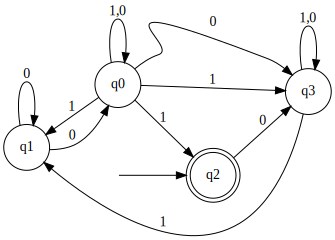

In [48]:
nfa.plot()